### CNN (Convolutional Neural Networks)

Now we're going to get specific and see how a special kind of neural network, convolutional neural networks (CNNs) can be used for computer vision (detecting patterns in visual data).

* 🔑 Note: In deep learning, many different kinds of model architectures can be used for different problems. For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some architectures typically work better than others.

For example, you might want to:

* Classify whether a picture of food contains pizza 🍕 or steak 🥩 (we're going to do this)
* Detect whether or not an object appears in an image (e.g. did a specific car pass through a security camera?)


### Getting the Data

* The images we're going to work with are from the Food-101 dataset, a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes.

* To begin, we're only going to use two of the categories, pizza 🍕 and steak 🥩 and build a binary classifier.

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2024-01-06 12:56:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  23.1MB/s    in 5.7s    

2024-01-06 12:56:28 (18.4 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



### Analyse the data

In [2]:
!ls pizza_steak

test  train


In [3]:
# Code snippet to find number of files in the directory
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in 'pizza_steak'
There are 2 directories and 0 images in 'pizza_steak/train'
There are 0 directories and 750 images in 'pizza_steak/train/steak'
There are 0 directories and 750 images in 'pizza_steak/train/pizza'
There are 2 directories and 0 images in 'pizza_steak/test'
There are 0 directories and 250 images in 'pizza_steak/test/steak'
There are 0 directories and 250 images in 'pizza_steak/test/pizza'


In [4]:
# Another way to find number of images in a directory

num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

In [5]:
# Get the classnames programatically
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt


data_dir = pathlib.Path("pizza_steak/train")

# Created a list of class names from subdirectories
class_names = np.array(sorted(item.name for item in data_dir.glob("*")))
print(class_names)

['pizza' 'steak']


In [6]:
# Visualising the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Set up target directory
  target_folder = target_dir + target_class

  # Get a random image
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read the image and plot using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (384, 512, 3)


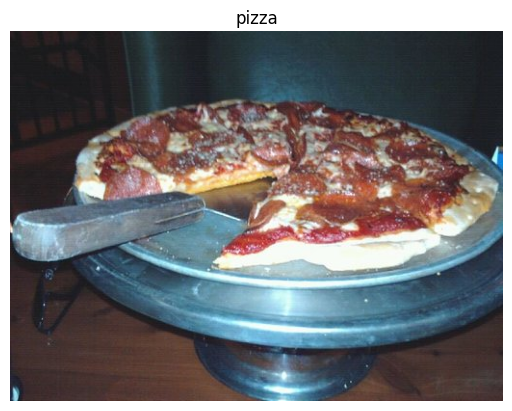

In [7]:
# Plot a random image from the train directory

img  = view_random_image(target_dir = "pizza_steak/train/",
                         target_class = "pizza")

In [8]:
# Return height, width and colour channels
img.shape

(384, 512, 3)

Looking at the image shape more closely, you'll see it's in the form (Width, Height, Colour Channels).

* In our case, the width and height vary but because we're dealing with colour images, the colour channels value is always 3. This is for different values of red, green and blue (RGB) pixels.

* You'll notice all of the values in the img array are between 0 and 255. This is because that's the possible range for red, green and blue values.

* For example, a pixel with a value red=0, green=0, blue=255 will look very blue.

* So when we build a model to differentiate between our images of pizza and steak, it will be finding patterns in these different pixel values which determine what each class looks like.

* 🔑 Note: As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to scale (also referred to as normalize) their pixel values by dividing the image arrays by 255.

### An end to end example

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Pre - process the data (pixel values b/w 0 & 1 -> Normalisation / Scaling)
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# Set up paths to our data directories
train_dir = "/content/pizza_steak/train"
test_dir = "/content/pizza_steak/test"

# Import data from DIRs and turn them into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size = 32,
                                               target_size = (224, 224),
                                               class_mode = "binary",
                                               seed = 42)

valid_data = valid_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (224, 224),
                                               class_mode = "binary",
                                               seed = 42)


# Build a CNN model (Same as Tiny VGG)

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 10,
                           kernel_size = 3,
                           activation = "relu",
                           input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = 2,
                              padding = "valid"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])


# Compile our CNN Model

model_1.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model

history_1 = model_1.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 14s 163ms/step - loss: 0.5816 - accuracy: 0.6800 - val_loss: 0.3740 - val_accuracy: 0.8360
Epoch 2/5
47/47 [==============================] - 7s 144ms/step - loss: 0.4270 - accuracy: 0.8067 - val_loss: 0.3893 - val_accuracy: 0.8120
Epoch 3/5
47/47 [==============================] - 5s 112ms/step - loss: 0.4301 - accuracy: 0.8020 - val_loss: 0.3543 - val_accuracy: 0.8700
Epoch 4/5
47/47 [==============================] - 7s 141ms/step - loss: 0.3805 - accuracy: 0.8427 - val_loss: 0.3272 - val_accuracy: 0.8660
Epoch 5/5
47/47 [==============================] - 6s 137ms/step - loss: 0.3437 - accuracy: 0.8547 - val_loss: 0.3062 - val_accuracy: 0.8760


In [10]:
# Epoch 1/5
# 47/47 [==============================] - 95s 2s/step - loss: 0.5800 - accuracy: 0.6953 - val_loss: 0.4656 - val_accuracy: 0.7800

In [11]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

### Testing the previous model on this dataset

In [12]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (224, 224, 3)),
    tf.keras.layers.Dense(4, activation = "relu"),
    tf.keras.layers.Dense(4, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

history_2 = model_2.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 7s 109ms/step - loss: 1.0727 - accuracy: 0.4967 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 5s 107ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 6s 131ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 6s 125ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 5s 106ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [13]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Improving the previous model

In [14]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation = 'relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation = 'relu'),
  tf.keras.layers.Dense(100, activation = 'relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_3.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

history_3 = model_3.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 8s 117ms/step - loss: 3.5159 - accuracy: 0.6213 - val_loss: 1.0428 - val_accuracy: 0.6880
Epoch 2/5
47/47 [==============================] - 6s 122ms/step - loss: 0.7068 - accuracy: 0.7147 - val_loss: 0.8425 - val_accuracy: 0.7000
Epoch 3/5
47/47 [==============================] - 6s 120ms/step - loss: 0.5647 - accuracy: 0.7700 - val_loss: 0.4664 - val_accuracy: 0.7760
Epoch 4/5
47/47 [==============================] - 6s 134ms/step - loss: 0.5418 - accuracy: 0.7800 - val_loss: 1.0841 - val_accuracy: 0.5500
Epoch 5/5
47/47 [==============================] - 5s 104ms/step - loss: 0.6012 - accuracy: 0.7540 - val_loss: 0.8683 - val_accuracy: 0.6000


In [15]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15073201 (57.50 MB)
Trainable params: 15073201 (57.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Binary Classification - Break down

Image shape: (512, 512, 3)
Image shape: (512, 384, 3)


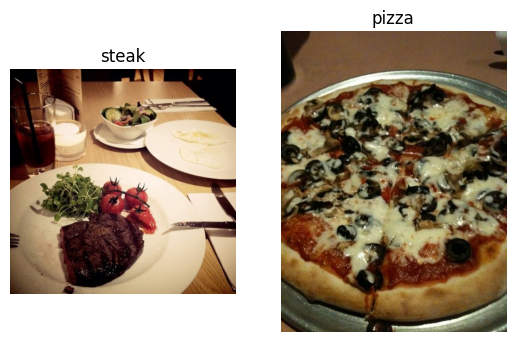

In [16]:
# Visualise the data
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

Our next step is to turn our data into batches.

* A batch is a small subset of the dataset a model looks at during training. For example, rather than looking at 10,000 images at one time and trying to figure out the patterns, a model might only look at 32 images at a time.

It does this for a couple of reasons:

* 10,000 images (or more) might not fit into the memory of your processor (GPU).
Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.
Why 32?

* A batch size of 32 is good for your health.

* No seriously, there are many different batch sizes you could use but 32 has proven to be very effective in many different use cases and is often the default for many data preprocessing functions.

* To turn our data into batches, we'll first create an instance of ImageDataGenerator for each of our datasets.

In [17]:
!nvidia-smi

Sat Jan  6 12:58:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0              27W /  70W |   1665MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
# Create train and test data generators and scale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.0)
test_datagen = ImageDataGenerator(rescale = 1/255.0)

In [19]:
# Load data from directories and turn them into batches

train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               target_size = (224, 224),
                                               class_mode = "binary",
                                               batch_size = 32)

test_data = test_datagen.flow_from_directory(directory = test_dir,
                                               target_size = (224, 224),
                                               class_mode = "binary",
                                               batch_size = 32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [20]:
# Get a sample of train data batch
images, labels = train_data.next()
len(images), len(labels)

(32, 32)

### Create a CNN model (Baseline)

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Sequential


model_4 = Sequential([
    Conv2D(filters = 10,
           kernel_size = 3,
           strides = 1,
           padding = "valid",
           activation = "relu",
           input_shape = (224, 224, 3)),
    Conv2D(10, 3, activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    Flatten(),
    Dense(1, activation = "sigmoid")
])


model_4.compile(loss = "binary_crossentropy",
                optimizer = Adam(),
                metrics = ["accuracy"])

len(train_data), len(test_data)

(47, 16)

In [22]:
history_4 = model_4.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 8s 143ms/step - loss: 1.0579 - accuracy: 0.6593 - val_loss: 0.4521 - val_accuracy: 0.8000
Epoch 2/5
47/47 [==============================] - 5s 113ms/step - loss: 0.4227 - accuracy: 0.8160 - val_loss: 0.4386 - val_accuracy: 0.7960
Epoch 3/5
47/47 [==============================] - 6s 136ms/step - loss: 0.3003 - accuracy: 0.9000 - val_loss: 0.4830 - val_accuracy: 0.7740
Epoch 4/5
47/47 [==============================] - 6s 119ms/step - loss: 0.1672 - accuracy: 0.9380 - val_loss: 0.4200 - val_accuracy: 0.8300
Epoch 5/5
47/47 [==============================] - 7s 144ms/step - loss: 0.0663 - accuracy: 0.9827 - val_loss: 0.4373 - val_accuracy: 0.8120


<Axes: >

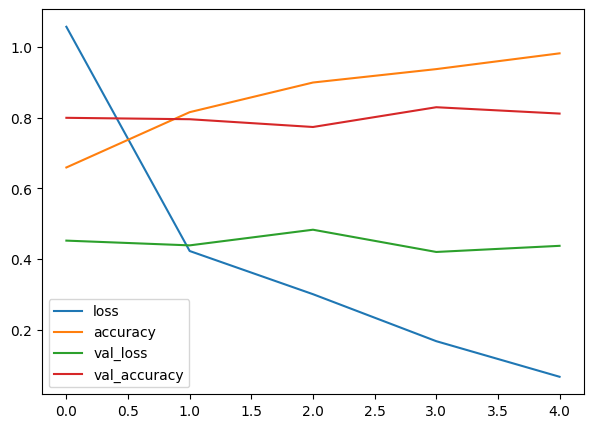

In [23]:
import pandas as pd

pd.DataFrame(history_4.history).plot(figsize = (7, 5))

In [24]:
# Plot the validation and training curves separately

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  # How many epochs were run ?
  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "validation_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "validation_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

* 🔑 Note: When a model's validation loss starts to increase, it's likely that it's overfitting the training dataset. This means, it's learning the patterns in the training dataset too well and thus its ability to generalize to unseen data will be diminished.

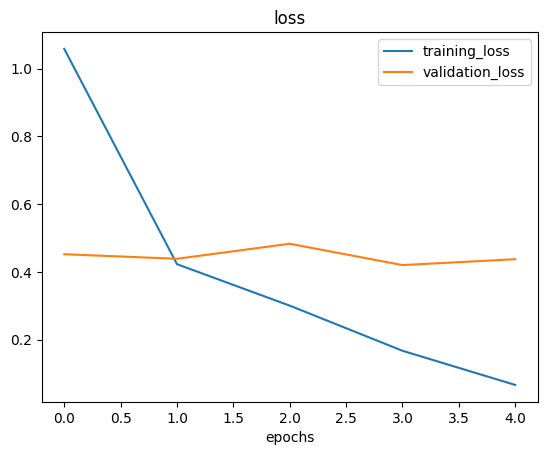

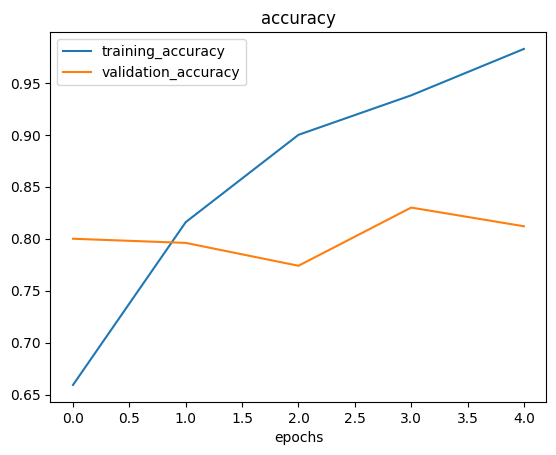

In [25]:
plot_loss_curves(history_4)

And there are even a few more things we could try to further overfit our model:

* Increase the number of convolutional layers.
* Increase the number of convolutional filters.
* Add another dense layer to the output of our flattened layer.

How to reduce overfitting :

* Add data augmentation
* Add regularization (MaxPool2D)
* Add more data

So for the next few models we build, we're going to adjust a number of parameters and inspect the training curves along the way.

Namely, we'll build 2 more models:

* A ConvNet with max pooling
* A ConvNet with max pooling and data augmentation
For the first model, we'll follow the modified basic CNN structure:

Input -> Conv layers + ReLU layers (non-linearities) + Max Pooling layers -> Fully connected (dense layer) as Output

In [27]:
# Create a model for new baseline

model_5 = Sequential([
    Conv2D(10, 3, activation = "relu", input_shape = (224, 224, 3)),
    MaxPool2D(pool_size = 2),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = "sigmoid")
])

In [28]:
# Compile the model

model_5.compile(loss = "binary_crossentropy",
                optimizer = Adam(),
                metrics = ["accuracy"])

In [29]:
# Fit the model

history_5 = model_5.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 8s 133ms/step - loss: 0.6254 - accuracy: 0.6447 - val_loss: 0.4556 - val_accuracy: 0.8240
Epoch 2/5
47/47 [==============================] - 6s 137ms/step - loss: 0.4368 - accuracy: 0.7980 - val_loss: 0.3526 - val_accuracy: 0.8400
Epoch 3/5
47/47 [==============================] - 5s 113ms/step - loss: 0.4030 - accuracy: 0.8240 - val_loss: 0.3493 - val_accuracy: 0.8760
Epoch 4/5
47/47 [==============================] - 5s 108ms/step - loss: 0.3727 - accuracy: 0.8360 - val_loss: 0.3175 - val_accuracy: 0.8800
Epoch 5/5
47/47 [==============================] - 7s 151ms/step - loss: 0.3516 - accuracy: 0.8527 - val_loss: 0.2970 - val_accuracy: 0.8880


In [30]:
# Get a summary of model with max pooling

model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 10)       

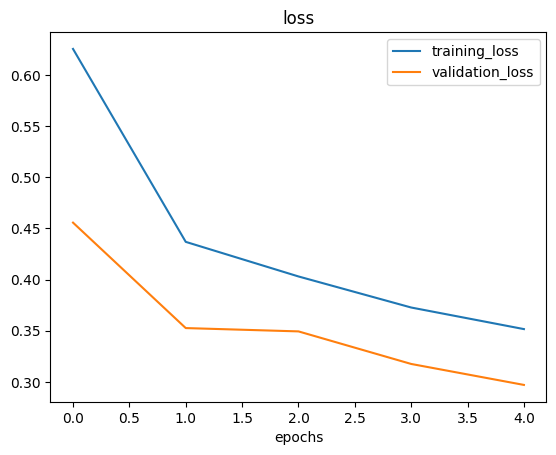

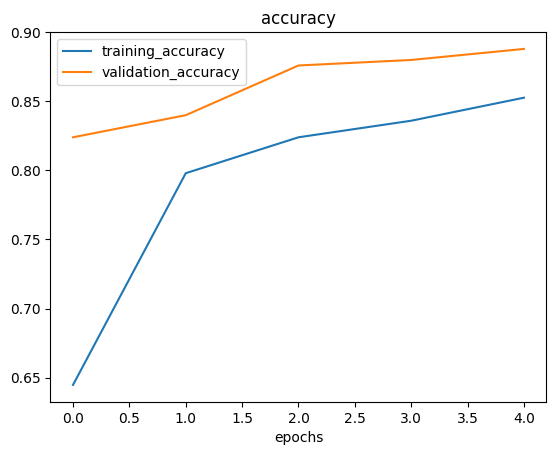

In [31]:
plot_loss_curves(history_5)

### Using Data Augmentation to reduce overfitting

* Data augmentation is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

* Doing this simulates the kind of data a model might be used on in the real world.

* 🔑 Note: Data augmentation is usally only performed on the training data. Using the ImageDataGenerator built-in data augmentation parameters our images are left as they are in the directories but are randomly manipulated when loaded into the model.

In [32]:
# Create ImageDataGenerator training instance with Data Augmentation

train_datagen_augmented = ImageDataGenerator(rescale = 1/255.0,
                                             rotation_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.3,
                                             horizontal_flip = True)

# Create ImageDataGenerator without Data Augmentation

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [34]:
# Import data amd augment it from training directory

print("Augmented training data : ")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size = (224, 224),
                                                                   class_mode = "binary",
                                                                   batch_size = 32,
                                                                   shuffle = False)

# Create non augmented training data

print("Non Augmented training data")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224, 224),
                                               class_mode = "binary",
                                               batch_size = 32,
                                               shuffle = False)

# Create non augmented test data

print("Non Augmented test data")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (224, 224),
                                             class_mode = "binary",
                                             batch_size = 32,
                                             shuffle = False)

Augmented training data : 
Found 1500 images belonging to 2 classes.
Non Augmented training data
Found 1500 images belonging to 2 classes.
Non Augmented test data
Found 500 images belonging to 2 classes.


In [35]:
# Get sample data batches

images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next()

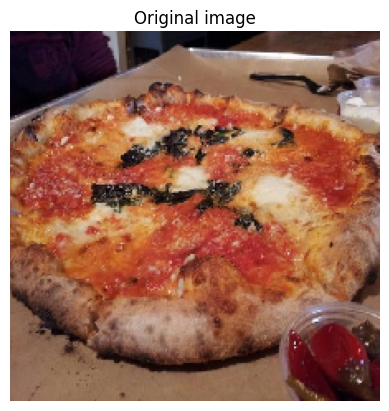

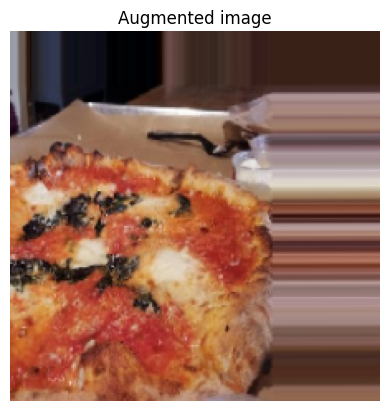

In [41]:
# Show the original image and augmented image
import random
random_number = random.randint(0, 31)

plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [42]:
# Build a model to fit on augmented data

model_6 = Sequential([
    Conv2D(10, 3, activation = "relu", input_shape = (224, 224, 3)),
    MaxPool2D(pool_size = 2),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = "sigmoid")
])

model_6.compile(loss = "binary_crossentropy",
                optimizer = Adam(),
                metrics = ["accuracy"])


history_6 = model_6.fit(train_data_augmented,
                        epochs = 5,
                        steps_per_epoch = len(train_data_augmented),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 21s 414ms/step - loss: 0.6965 - accuracy: 0.4580 - val_loss: 0.6918 - val_accuracy: 0.5840
Epoch 2/5
47/47 [==============================] - 21s 442ms/step - loss: 0.6949 - accuracy: 0.5033 - val_loss: 0.6925 - val_accuracy: 0.5040
Epoch 3/5
47/47 [==============================] - 21s 440ms/step - loss: 0.6967 - accuracy: 0.5060 - val_loss: 0.6920 - val_accuracy: 0.5420
Epoch 4/5
47/47 [==============================] - 20s 418ms/step - loss: 0.6924 - accuracy: 0.5687 - val_loss: 0.6887 - val_accuracy: 0.5500
Epoch 5/5
47/47 [==============================] - 21s 458ms/step - loss: 0.6982 - accuracy: 0.5013 - val_loss: 0.6881 - val_accuracy: 0.7300


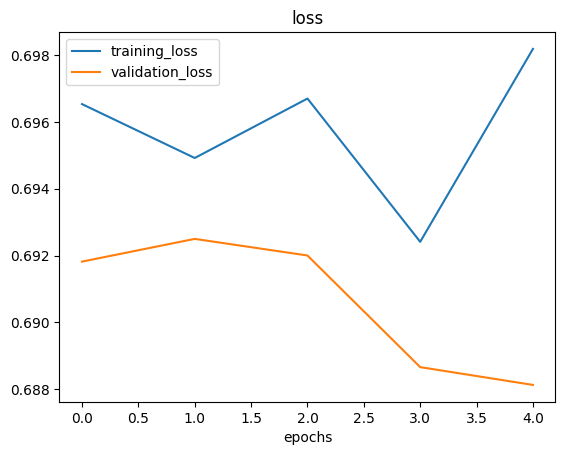

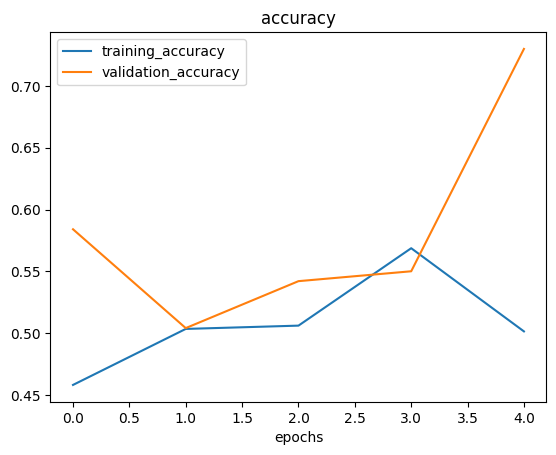

In [43]:
plot_loss_curves(history_6)

* Shuffle the data for better results

In [44]:
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size = (224, 224),
                                                                   class_mode = "binary",
                                                                   batch_size = 32,
                                                                   shuffle = True)

Found 1500 images belonging to 2 classes.


In [47]:
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 22s 444ms/step - loss: 0.6806 - accuracy: 0.5687 - val_loss: 0.5767 - val_accuracy: 0.7740
Epoch 2/5
47/47 [==============================] - 21s 441ms/step - loss: 0.5675 - accuracy: 0.7200 - val_loss: 0.3903 - val_accuracy: 0.8380
Epoch 3/5
47/47 [==============================] - 21s 448ms/step - loss: 0.5335 - accuracy: 0.7367 - val_loss: 0.3911 - val_accuracy: 0.8440
Epoch 4/5
47/47 [==============================] - 20s 423ms/step - loss: 0.5161 - accuracy: 0.7453 - val_loss: 0.3872 - val_accuracy: 0.8560
Epoch 5/5
47/47 [==============================] - 21s 449ms/step - loss: 0.4984 - accuracy: 0.7707 - val_loss: 0.3941 - val_accuracy: 0.8340


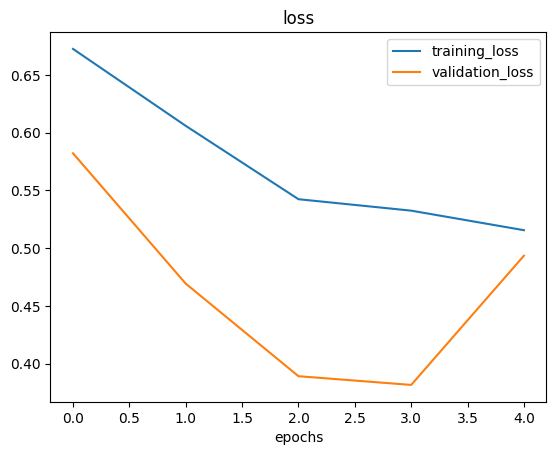

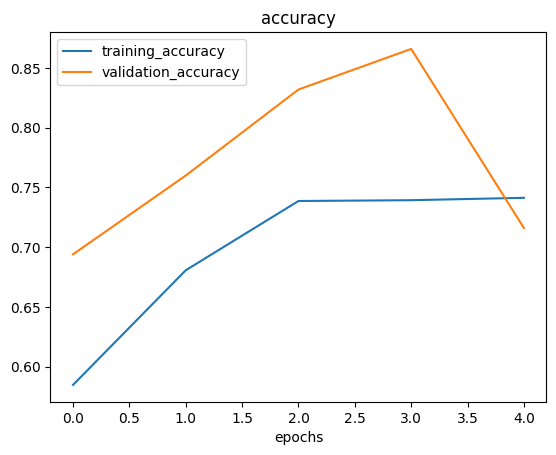

In [46]:
plot_loss_curves(history_7)

### More Steps until satisfied

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:

* Increase the number of model layers (e.g. add more convolutional layers).
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
* Train for longer (more epochs).
* Finding an ideal learning rate.
* Get more data (give the model more opportunities to learn).
* Use transfer learning to leverage what another image model has learned and adjust it for our own use case.

Adjusting each of these settings (except for the last two) during model development is usually referred to as hyperparameter tuning.

### Making prediction on custom images

In [48]:
print(class_names)

['pizza' 'steak']


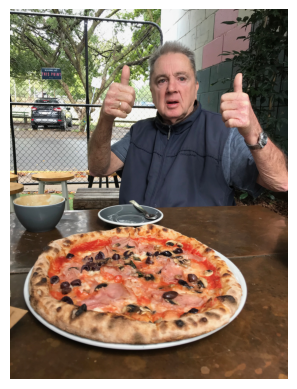

In [54]:
# View the example image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

pizza = mpimg.imread("03-pizza-dad.jpeg")
plt.imshow(pizza)
plt.axis(False);

In [55]:
pizza.shape

(4032, 3024, 3)

In [59]:
expanded_pizza = tf.expand_dims(pizza, axis = 0)

In [68]:
# Create a helper function to prepare our image

def load_and_prep_image(filename, img_shape = 224):
     """
     Reads an image and turns it into tensor, reshapes to (img_shape, img_shape, color_channels)
     """

     # Read the image
     img = tf.io.read_file(filename)
     # Decode the read file into tensor
     img = tf.image.decode_image(img)
     # Resize the image
     img = tf.image.resize(img, size = [img_shape, img_shape])
     # Rescale the image
     img = img / 255.
     return img

In [69]:
pizza = load_and_prep_image("03-pizza-dad.jpeg")

In [70]:
model_7.predict(tf.expand_dims(pizza, axis = 0))

1/1 [==============================] - 0s 252ms/step


array([[0.5851832]], dtype=float32)

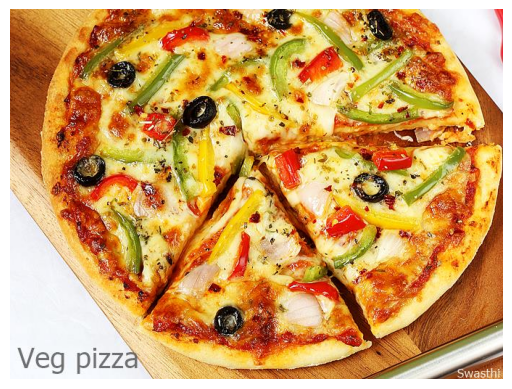

In [71]:
piz2 = mpimg.imread("pizza-recipe-1.jpg")
plt.imshow(piz2)
plt.axis(False);

In [73]:
piz2 = load_and_prep_image("pizza-recipe-1.jpg")

In [78]:
pred = model_7.predict(tf.expand_dims(piz2, axis = 0))

1/1 [==============================] - 0s 17ms/step


In [80]:
pred_class = class_names[int(tf.round(pred))]
pred_class

'pizza'

In [83]:
def pred_and_plot(model, filename, class_names = class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

### Multi - class Image Classification using CNNs

#### Importing the data

In [85]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-01-06 15:42:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  21.9MB/s    in 24s     

2024-01-06 15:42:50 (20.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [86]:
# Setup the train and test directories

train_dir = "/content/10_food_classes_all_data/train"
test_dir = "/content/10_food_classes_all_data/test"

In [88]:
# Getting the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)

class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


#### Pre - process the data

In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# Load the data from directories

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224, 224),
                                               batch_size = 32,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (224, 224),
                                             batch_size = 32,
                                             class_mode = "categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


#### Create a model (baseline) similar to CNN explainer

In [92]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation


model_8 = Sequential([
    Conv2D(10, 3, input_shape = (224, 224, 3)),
    Activation(activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation = "softmax")
])


model_8.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


history_8 = model_8.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 33s 134ms/step - loss: 2.1697 - accuracy: 0.1909 - val_loss: 2.0950 - val_accuracy: 0.2412
Epoch 2/5
235/235 [==============================] - 32s 136ms/step - loss: 1.9671 - accuracy: 0.3107 - val_loss: 1.9414 - val_accuracy: 0.3116
Epoch 3/5
235/235 [==============================] - 28s 118ms/step - loss: 1.7098 - accuracy: 0.4191 - val_loss: 1.9094 - val_accuracy: 0.3264
Epoch 4/5
235/235 [==============================] - 28s 117ms/step - loss: 1.2958 - accuracy: 0.5719 - val_loss: 2.0509 - val_accuracy: 0.3328
Epoch 5/5
235/235 [==============================] - 33s 141ms/step - loss: 0.7437 - accuracy: 0.7593 - val_loss: 2.6280 - val_accuracy: 0.2836


#### Evaluating our model

In [93]:
model_8.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 2.6280 - accuracy: 0.2836


[2.6280226707458496, 0.28360000252723694]

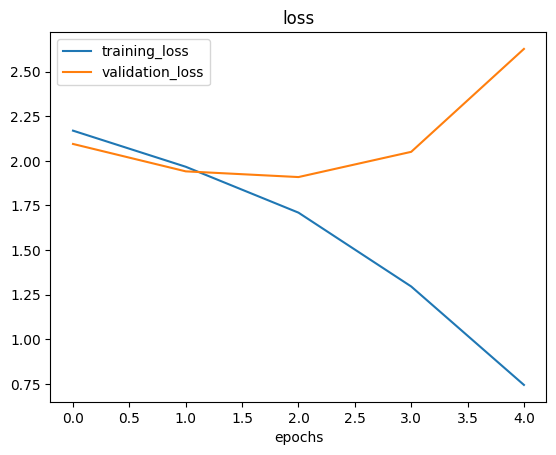

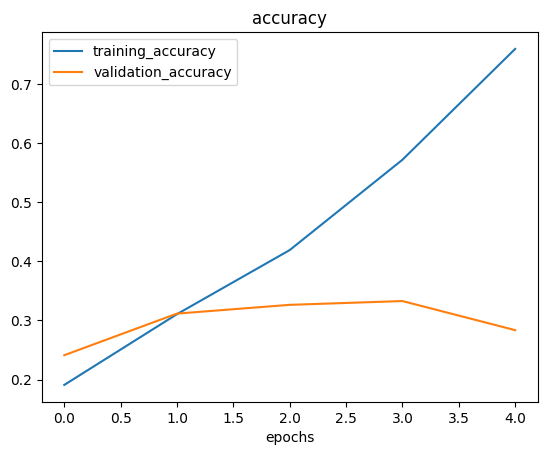

In [94]:
plot_loss_curves(history_8)

* Our model is **Over Fitting** , we need to improve that

#### Adjusting the hyper - parameters

* So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

* Get more data - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
* Simplify model - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
* Use data augmentation - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
* Use transfer learning - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.
* 🔑 Note: Preventing overfitting is also referred to as regularization.

In [95]:
# Make a simpler model

model_10 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

model_10.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_10 = model_10.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 30s 119ms/step - loss: 2.1572 - accuracy: 0.2125 - val_loss: 1.9879 - val_accuracy: 0.2916
Epoch 2/5
235/235 [==============================] - 27s 114ms/step - loss: 1.8215 - accuracy: 0.3719 - val_loss: 1.9015 - val_accuracy: 0.3436
Epoch 3/5
235/235 [==============================] - 27s 113ms/step - loss: 1.3699 - accuracy: 0.5524 - val_loss: 1.9538 - val_accuracy: 0.3412
Epoch 4/5
235/235 [==============================] - 26s 111ms/step - loss: 0.8592 - accuracy: 0.7333 - val_loss: 2.2388 - val_accuracy: 0.3056
Epoch 5/5
235/235 [==============================] - 26s 112ms/step - loss: 0.4611 - accuracy: 0.8675 - val_loss: 2.7318 - val_accuracy: 0.3048


#### Using Data Augmentation

In [96]:
train_data_augmented = ImageDataGenerator(rescale = 1/255.,
                                          rotation_range = 0.2,
                                          zoom_range = 0.2,
                                          width_shift_range = 0.2,
                                          height_shift_range = 0.2,
                                          horizontal_flip = True)

train_data_augmented = train_data_augmented.flow_from_directory(train_dir,
                                                                target_size = (224, 224),
                                                                batch_size = 32,
                                                                class_mode = "categorical")

Found 7500 images belonging to 10 classes.


In [98]:
model_11 = tf.keras.models.clone_model(model_10)

model_11.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_11 = model_11.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 101s 425ms/step - loss: 2.1805 - accuracy: 0.2060 - val_loss: 2.0387 - val_accuracy: 0.2648
Epoch 2/5
235/235 [==============================] - 100s 428ms/step - loss: 2.0682 - accuracy: 0.2727 - val_loss: 1.9013 - val_accuracy: 0.3436
Epoch 3/5
235/235 [==============================] - 99s 423ms/step - loss: 1.9982 - accuracy: 0.3029 - val_loss: 1.8757 - val_accuracy: 0.3480
Epoch 4/5
235/235 [==============================] - 102s 435ms/step - loss: 1.9722 - accuracy: 0.3119 - val_loss: 1.8211 - val_accuracy: 0.3784
Epoch 5/5
235/235 [==============================] - 102s 436ms/step - loss: 1.9408 - accuracy: 0.3244 - val_loss: 1.8255 - val_accuracy: 0.3804


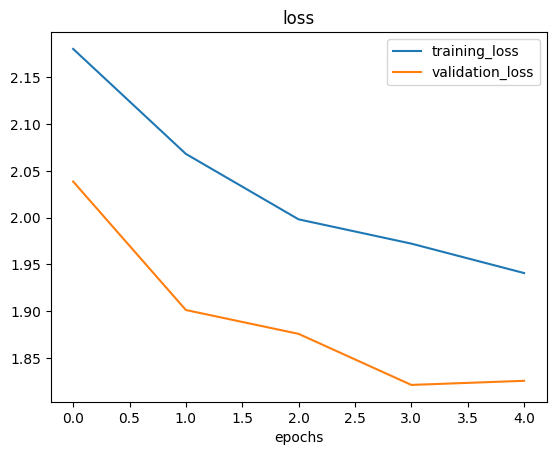

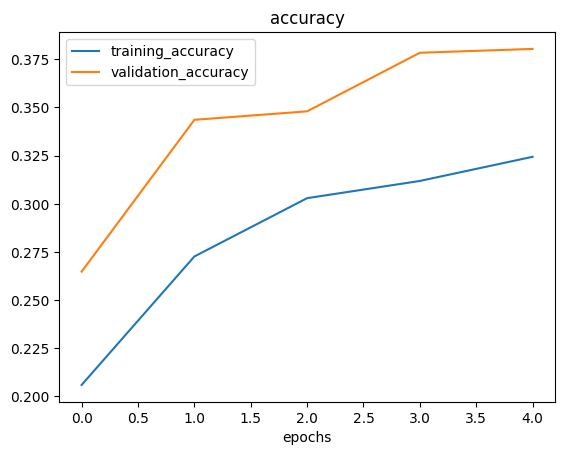

In [99]:
plot_loss_curves(history_11)

#### Repeat untill satisfied

* We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But as you could image, this could take a fairly long time.

* Good thing there's still one trick we haven't tried yet and that's transfer learning.

#### Making predictions on the model

In [101]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [102]:
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

1/1 [==============================] - 0s 84ms/step


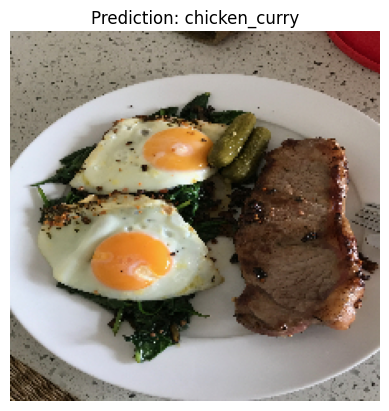

In [103]:
pred_and_plot(model=model_11,
              filename="03-steak.jpeg",
              class_names=class_names)

1/1 [==============================] - 0s 30ms/step


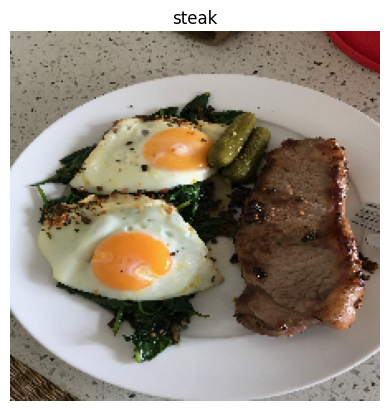

In [104]:
# Load in and preprocess our custom image
img = load_and_prep_image("03-steak.jpeg")

# Make a prediction
pred = model_11.predict(tf.expand_dims(img, axis=0))

# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False);

In [105]:
# Adjust function to work with multi-class
def pred_and_plot2(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 48ms/step


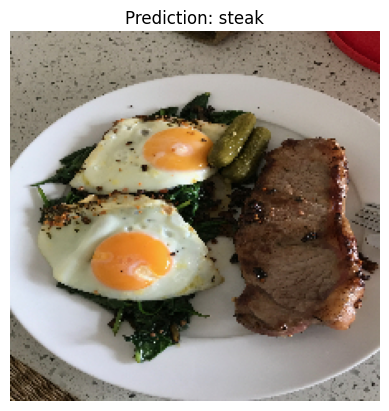

In [106]:
pred_and_plot2(model_11, "03-steak.jpeg", class_names)

#### Saving and loading our model

In [107]:
model_11.save("multi_class_model")

In [109]:
loaded_model_11 = tf.keras.models.load_model("multi_class_model")
loaded_model_11.evaluate(test_data)

79/79 [==============================] - 9s 116ms/step - loss: 1.8255 - accuracy: 0.3804


[1.8255091905593872, 0.38040000200271606]

In [110]:
model_11.evaluate(test_data)

79/79 [==============================] - 7s 88ms/step - loss: 1.8255 - accuracy: 0.3804


[1.8255091905593872, 0.38040000200271606]